In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report

import joblib
import itertools

import preprocessing as pp

from importlib import reload
pd.options.mode.chained_assignment = None

In [97]:
reload(pp);

In [98]:
#Load dataset, regroup classification in superclasses, and keep only those with data > 5000, other are regrouped in "other_classes"
df = pp.load_datasets()
df = pp.prepare_target(df, strategy='regroup')

Complete DataFrame has 471149 lines and 16 columns
Final DataFrame has 471149 lines and 16 columns after regrouping all classes with less than 5000 items


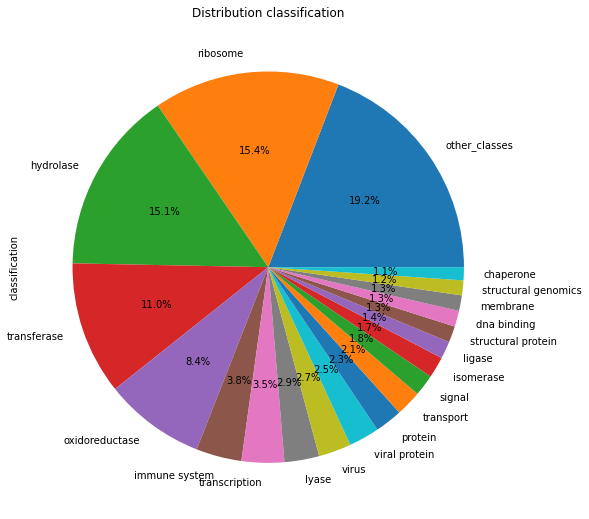

In [140]:
df.classification.value_counts().plot(kind="pie", figsize=(9,9), title='Distribution classification', autopct='%1.1f%%');

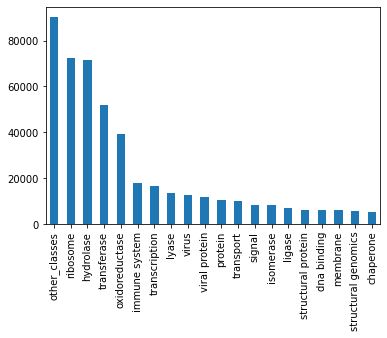

In [141]:
df.classification.value_counts().plot(kind='bar');
#Other classes regroup several classes, worth being kept to be able to check if the model can 
#properly detect that. Studying the behavior of this other_classes may also be relevant

In [101]:
#Get  train / test data 
data = df.drop('classification', axis = 1)
target = df.classification
X_train, X_test, y_train,  y_test = train_test_split(data, target, test_size=0.3, random_state=452)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((329804, 15), (141345, 15), (329804,), (141345,))

In [102]:
#Feature selection
rfe = RFE(ExtraTreesClassifier(), n_features_to_select=6,verbose=1)

In [103]:
#Pipeline
# We made predictions without Features reduction
# Only 12 features, and all of them seems important to not have more unbalanced data, no need to reduce
# Also, it does not take much time to take all 12 than reduce to 8 or Even 4 as suggested by RFECV test
steps = [('preprocessing', pp.PreprocessingTransformer(verbose=True)),
         #('rfe', rfe),
         ('clf', ExtraTreesClassifier())
         ]


pipe = Pipeline(steps, verbose=True)
pipe.fit(X_train, y_train)

-- Fit done -- 
1.Drop useless columns
2.Replace missing values in X
3.Reduce modalities
4.Correct skewness
5.scale and encode categ values
-- Preprocessing done -- 
[Columns] :  Index(['residueCount', 'resolution', 'structureMolecularWeight',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'macromoleculeType_DNA', 'macromoleculeType_Protein',
       'macromoleculeType_RNA', 'phValue_acide', 'phValue_basique',
       'phValue_neutre'],
      dtype='object')
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   7.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  59.9s


Pipeline(steps=[('preprocessing', PreprocessingTransformer()),
                ('clf', ExtraTreesClassifier())],
         verbose=True)

In [104]:
print("score on Train set:", pipe.score(X_train, y_train))
print("score on Test set:", pipe.score(X_test, y_test))

1.Drop useless columns
2.Replace missing values in X
3.Reduce modalities
4.Correct skewness
5.scale and encode categ values
-- Preprocessing done -- 
[Columns] :  Index(['residueCount', 'resolution', 'structureMolecularWeight',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'macromoleculeType_DNA', 'macromoleculeType_Protein',
       'macromoleculeType_RNA', 'phValue_acide', 'phValue_basique',
       'phValue_neutre'],
      dtype='object')
score on Train set: 0.9995330559968951
1.Drop useless columns
2.Replace missing values in X
3.Reduce modalities
4.Correct skewness
5.scale and encode categ values
-- Preprocessing done -- 
[Columns] :  Index(['residueCount', 'resolution', 'structureMolecularWeight',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'macromoleculeType_DNA', 'macromoleculeType_Protein',
       'macromoleculeType_RNA', 'phValue_acide', 'phValue_basique',
       'phValue_neutre'],
      dtype='object')
score on 

In [105]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

1.Drop useless columns
2.Replace missing values in X
3.Reduce modalities
4.Correct skewness
5.scale and encode categ values
-- Preprocessing done -- 
[Columns] :  Index(['residueCount', 'resolution', 'structureMolecularWeight',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'macromoleculeType_DNA', 'macromoleculeType_Protein',
       'macromoleculeType_RNA', 'phValue_acide', 'phValue_basique',
       'phValue_neutre'],
      dtype='object')
                     precision    recall  f1-score   support

          chaperone       0.91      0.83      0.87      1552
        dna binding       0.93      0.84      0.89      1956
          hydrolase       0.85      0.90      0.88     21367
      immune system       0.93      0.93      0.93      5200
          isomerase       0.94      0.84      0.89      2532
             ligase       0.94      0.81      0.87      2083
              lyase       0.95      0.88      0.92      4044
           membrane       0.89     

In [146]:
def plot_confusion_matrix(cm, classes):

    plt.figure(figsize=(15,15))
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ', fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=12)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=12,color='black')
    plt.xlabel('Predicted label',fontsize=12,color='black' )
    np.set_printoptions(precision=2)

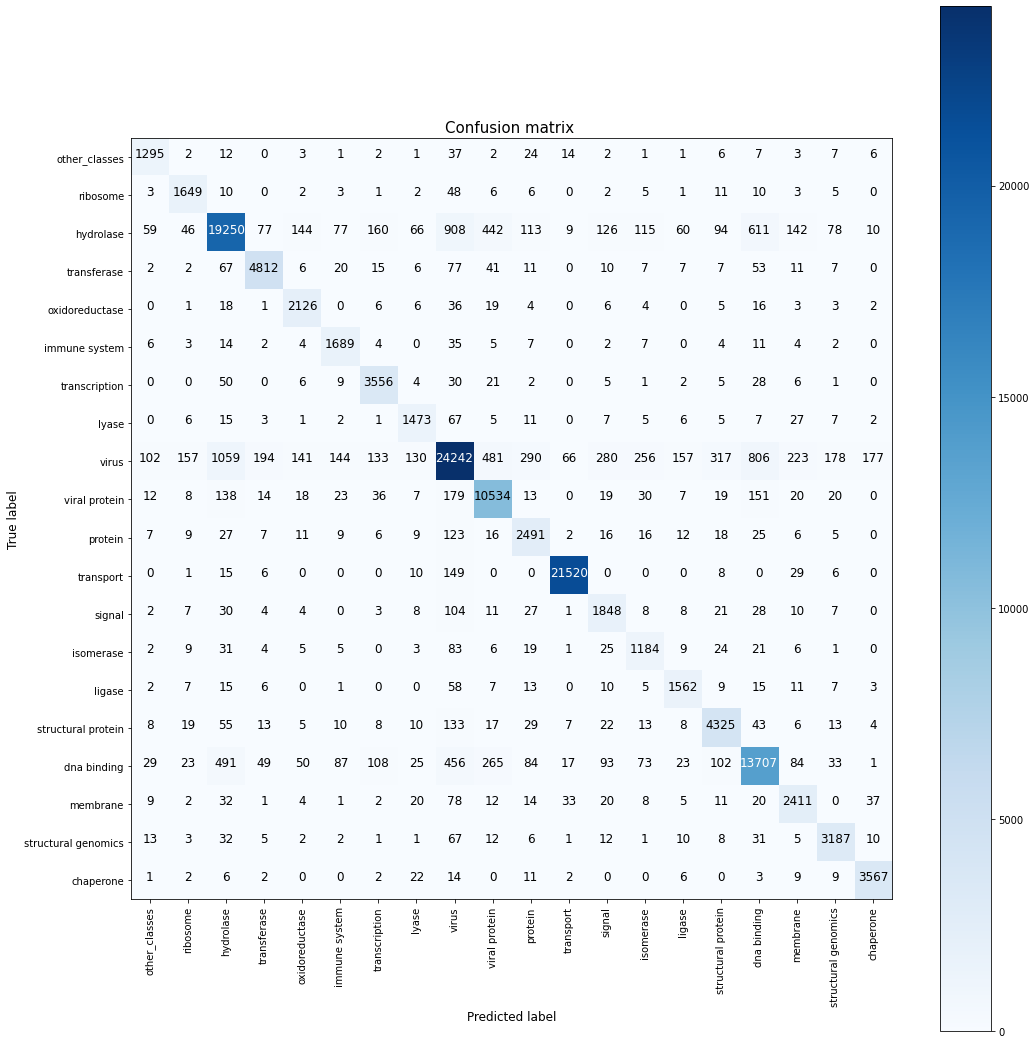

In [147]:
cm = confusion_matrix(y_pred,y_test)
plot_confusion_matrix(cm, y_train.value_counts().index)

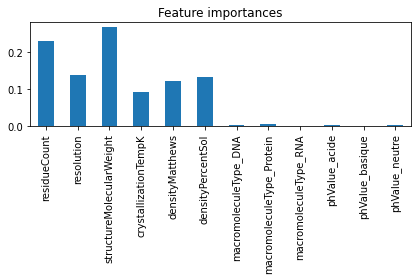

In [150]:
names = pipe['clf'].feature_names_in_
importances = pipe['clf'].feature_importances_
forest_importances = pd.Series(importances, index=names)

fig, ax = plt.subplots()
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()

In [106]:
joblib.dump(pipe['clf'], '../models/prot_clf.joblib')

['../models/prot_clf.joblib']

In [148]:
joblib.dump(pipe['preprocessing'], '../models/prot_preprocessing.joblib')


['../models/prot_preprocessing.joblib']